## DATA IMPORT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

# Set the download folder to the current directory
download_folder = os.path.abspath(".")

## check if the dataset is already downloaded
if not os.path.exists(os.path.join(download_folder, "lfw_home")):
    print("Downloading LFW dataset...")
else:
    print("LFW dataset already downloaded.")

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4, download_if_missing=True, data_home=download_folder)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


## TRAIN/TEST SPLIT and EXPLORATORY DATA ANALYSIS

In [2]:
# Load the data and labels into the variables X and y using the function train_test_split
# Set the test size to 0.25 and random_state to 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Print the shape of X_train, X_test, y_train, y_test
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

# Print the number of unique labels in y_train
print("Number of unique labels in y_train: ", np.unique(y_train).shape[0])

# Print the number of unique labels in y_test
print("Number of unique labels in y_test: ", np.unique(y_test).shape[0])

# Print the number of classes in the dataset
print("Number of classes in the dataset: ", np.unique(y).shape[0])

# Print the number of samples for each class in the training set
unique, counts = np.unique(y_train, return_counts=True)
print("Number of samples for each class in the training set: ", dict(zip(unique, counts)))

# Print the number of samples for each class in the test set
unique, counts = np.unique(y_test, return_counts=True)
print("Number of samples for each class in the test set: ", dict(zip(unique, counts)))

X_train shape:  (966, 1850)
X_test shape:  (322, 1850)
y_train shape:  (966,)
y_test shape:  (322,)
Number of unique labels in y_train:  7
Number of unique labels in y_test:  7
Number of classes in the dataset:  7
Number of samples for each class in the training set:  {0: 64, 1: 176, 2: 94, 3: 384, 4: 84, 5: 56, 6: 108}
Number of samples for each class in the test set:  {0: 13, 1: 60, 2: 27, 3: 146, 4: 25, 5: 15, 6: 36}


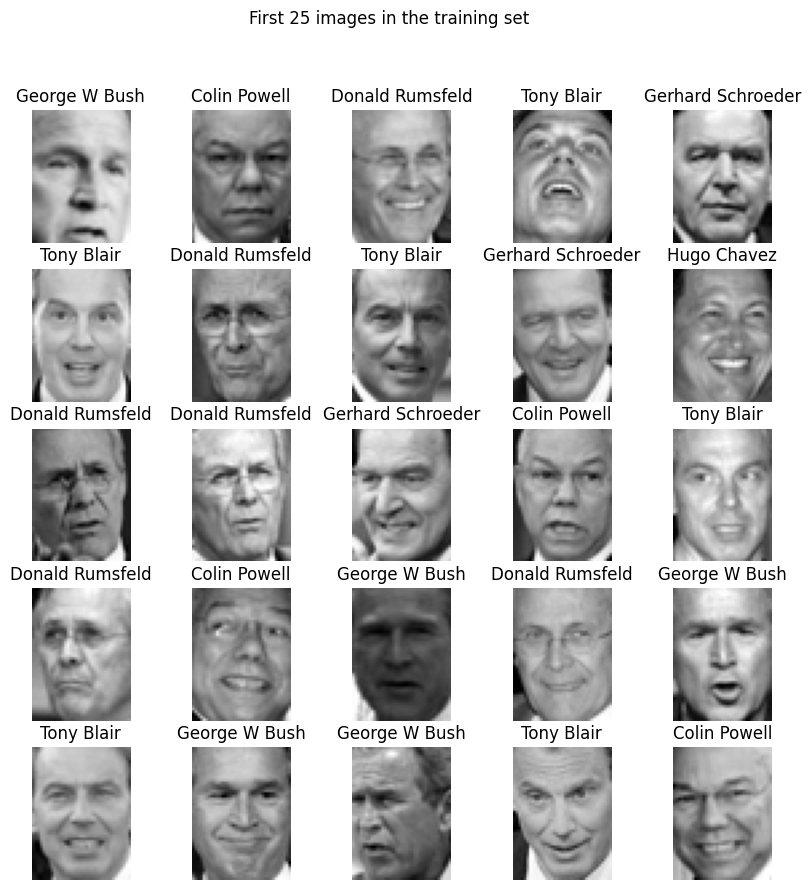

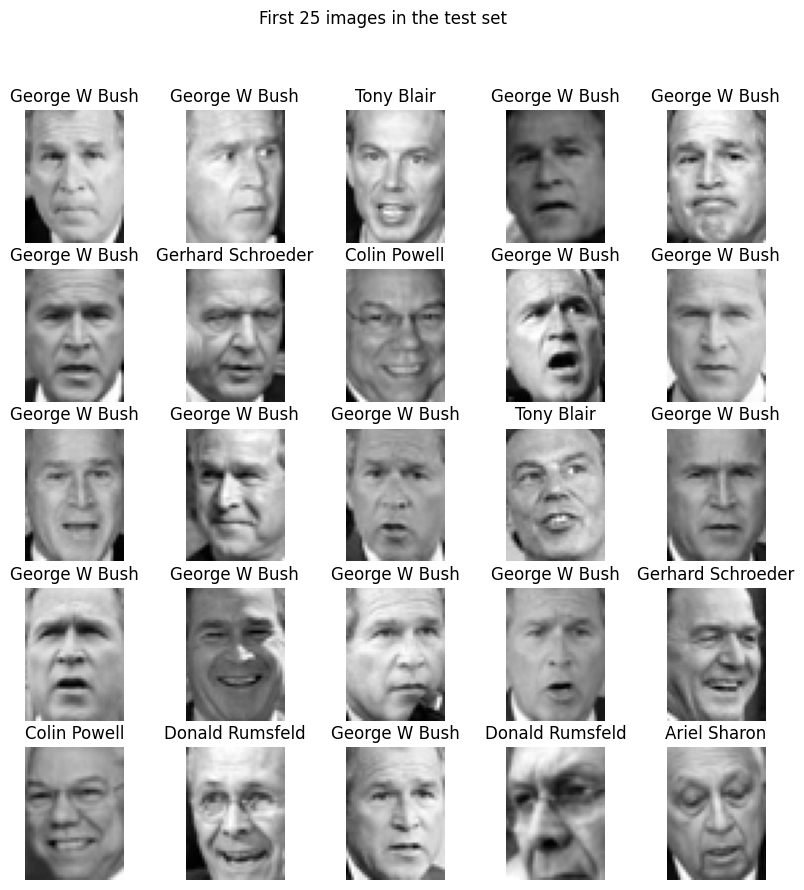

In [3]:
## Sample Plots
# Plot the first 25 images in the training set
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(target_names[y_train[i]])
    plt.axis('off')
plt.suptitle("First 25 images in the training set")
plt.show()

# Plot the first 25 images in the test set
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(target_names[y_test[i]])
    plt.axis('off')
plt.suptitle("First 25 images in the test set")
plt.show()


## CNN MODEL

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)

        # Calculate the dimensions after the third convolutional layer
        dummy_input = torch.randn(1, 1, h, w)
        dummy_output = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
        dummy_output = self.pool(F.relu(self.bn2(self.conv2(dummy_output))))
        dummy_output = F.relu(self.bn3(self.conv3(dummy_output)))
        self.fc1_input_dim = dummy_output.view(-1).shape[0]

        self.fc1 = nn.Linear(self.fc1_input_dim, 120)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, self.fc1_input_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x



# Define the training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_samples = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        total_samples += images.size(0)
    return running_loss / total_samples

# Define the testing function
def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
    return running_loss / total, correct / total


#### TRANSFORMATIONS AND DATA LOADERS

In [29]:
# Set up the data loaders
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
X_train_t = torch.tensor(X_train.reshape(-1, 1, h, w), dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test.reshape(-1, 1, h, w), dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, drop_last=True)


#### TRAIN MODEL

In [32]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the CNN model, loss function, and optimizer
model = Net(n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train and test the CNN
num_epochs = 300
train_losses = []
test_losses = []
accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = test(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')


Epoch 1/300, Train Loss: 2.0211, Test Loss: 1.9774, Test Accuracy: 0.1067
Epoch 2/300, Train Loss: 1.9601, Test Loss: 1.9522, Test Accuracy: 0.1067
Epoch 3/300, Train Loss: 1.9162, Test Loss: 1.9203, Test Accuracy: 0.1067
Epoch 4/300, Train Loss: 1.8769, Test Loss: 1.8745, Test Accuracy: 0.4633
Epoch 5/300, Train Loss: 1.8187, Test Loss: 1.8032, Test Accuracy: 0.4533
Epoch 6/300, Train Loss: 1.7819, Test Loss: 1.7098, Test Accuracy: 0.4533
Epoch 7/300, Train Loss: 1.7420, Test Loss: 1.6330, Test Accuracy: 0.4533
Epoch 8/300, Train Loss: 1.7123, Test Loss: 1.5894, Test Accuracy: 0.4533
Epoch 9/300, Train Loss: 1.6687, Test Loss: 1.5644, Test Accuracy: 0.4533
Epoch 10/300, Train Loss: 1.6615, Test Loss: 1.5466, Test Accuracy: 0.4533
Epoch 11/300, Train Loss: 1.6398, Test Loss: 1.5292, Test Accuracy: 0.4533
Epoch 12/300, Train Loss: 1.6293, Test Loss: 1.5071, Test Accuracy: 0.4600
Epoch 13/300, Train Loss: 1.6070, Test Loss: 1.4861, Test Accuracy: 0.4633
Epoch 14/300, Train Loss: 1.5826, 

#### SAVE MODEL

In [34]:
torch.save(model.state_dict(), 'model.pth')

#### LOAD MODEL

In [42]:
loaded_model = Net(n_classes)
loaded_model.load_state_dict(torch.load('model.pth'))
loaded_model = loaded_model.to(device)  # Move the model to the GPU
loaded_model.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2880, out_features=120, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)

#### PLOT ACCURACY AND LOSS

Test Loss: 0.3944, Test Accuracy: 0.9133


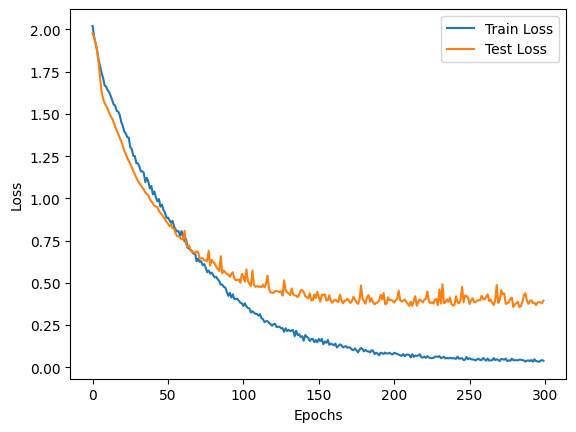

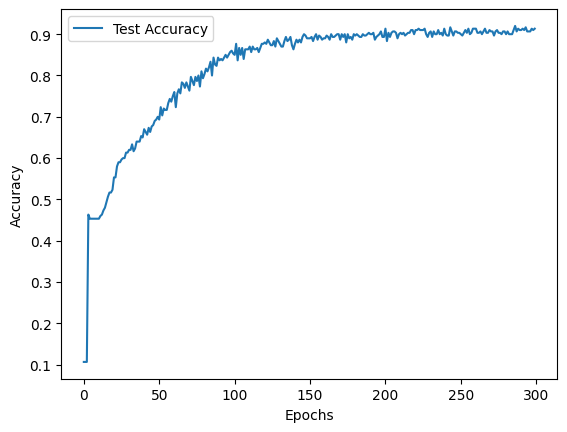

In [44]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, test_losses):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracies(accuracies):
    plt.figure()
    plt.plot(accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Evaluate the loaded model
test_loss, accuracy = test(loaded_model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Plot the training and test losses
plot_losses(train_losses, test_losses)

# Plot the test accuracies
plot_accuracies(accuracies)


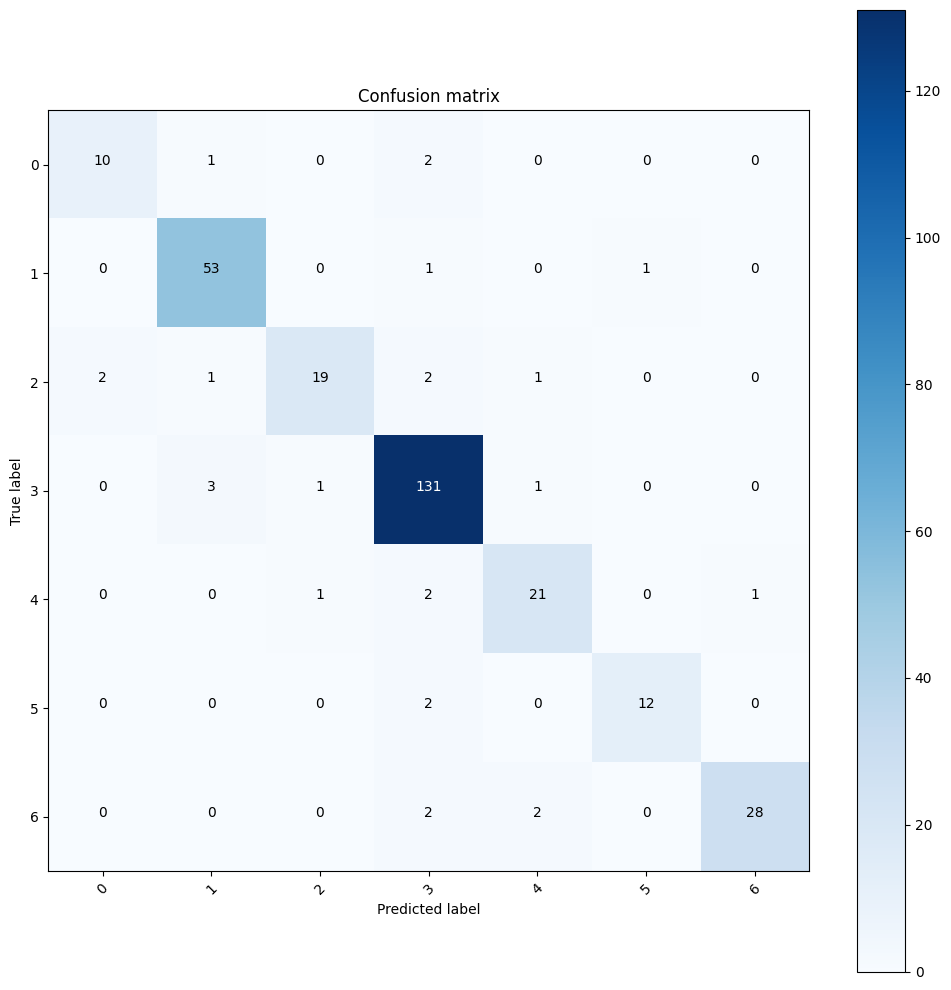

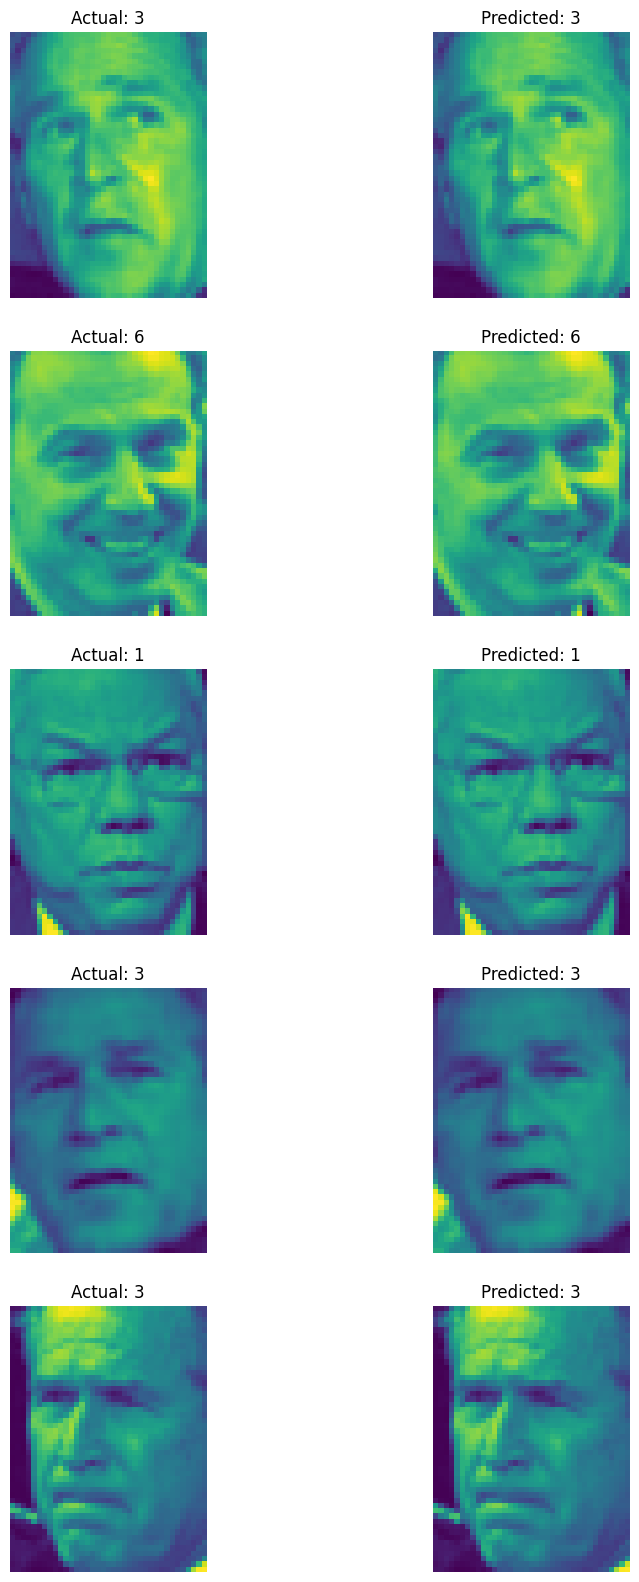

In [46]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


import random

def plot_actual_vs_predicted(model, loader, device, num_samples=5):
    model.eval()
    
    dataset_size = len(loader.dataset)
    random_indices = random.sample(range(dataset_size), num_samples)

    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))
    
    for i, index in enumerate(random_indices):
        inputs, labels = loader.dataset[index]
        inputs = inputs.unsqueeze(0).to(device)
        labels = torch.tensor([labels]).to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        img = inputs.cpu().numpy()[0].transpose((1, 2, 0))
        axs[i, 0].imshow(img)
        axs[i, 0].set_title(f'Actual: {labels.cpu().numpy()[0]}')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(img)
        axs[i, 1].set_title(f'Predicted: {preds.cpu().numpy()[0]}')
        axs[i, 1].axis('off')

    plt.show()


# Get predictions and true labels for the test dataset
true_labels = []
predicted_labels = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = loaded_model(inputs)
    _, preds = torch.max(outputs, 1)

    true_labels.extend(labels.cpu().numpy().tolist())
    predicted_labels.extend(preds.cpu().numpy().tolist())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
classes = [num for num in range(n_classes)]
plot_confusion_matrix(cm, classes=classes)  # Replace the classes list with your actual class names

# Plot actual vs. predicted images
plot_actual_vs_predicted(loaded_model, test_loader, device)


In [52]:
from sklearn.metrics import classification_report
class_names = [str(clas) for clas in classes]
# Convert integer class labels to string labels
true_labels = [class_names[label] for label in true_labels]
predicted_labels = [class_names[label] for label in predicted_labels]

# Generate classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.91      0.96      0.94        55
           2       0.90      0.76      0.83        25
           3       0.92      0.96      0.94       136
           4       0.84      0.84      0.84        25
           5       0.92      0.86      0.89        14
           6       0.97      0.88      0.92        32

    accuracy                           0.91       300
   macro avg       0.90      0.86      0.88       300
weighted avg       0.91      0.91      0.91       300

